# Auto Hierarchical Classification

This implementation is created for multiclass NLP problem.

And its my own implementation of the concepts provided in the paper below:


> Daniel Silva-Palacios, Cèsar Ferri, María José Ramírez-Quintana,
> **Improving Performance of Multiclass Classification by Inducing Class Hierarchies,**
> Procedia Computer Science,
> Volume 108,
> 2017,
> Pages 1692-1701,
> ISSN 1877-0509,
> https://doi.org/10.1016/j.procs.2017.05.218.
> (https://www.sciencedirect.com/science/article/pii/S1877050917308244)'''


## How it works?

The concept provided by Palacios et al. explains how to create a similarity matrix based on confusion matrix predicted by the model, and then group the most "confused" targets.

By applying that, I was able to improve the overall results for the text classifier model.

## Loading sample data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('input_data/train_40k.csv')

## Dataprep core functions

In [3]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer, SnowballStemmer
from string import punctuation
from unicodedata import normalize, combining
import unicodedata as ud

class Prep:
    def __init__(self, language='english'):
        self.language = language
        self.stopwords_list = stopwords.words(self.language)

    def clean_whitespaces(self, df: pd.DataFrame, cols: list):
        temp_df = df.copy()
        for col in cols:
            if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                temp_df[col] = temp_df[col].apply(lambda x: " ".join(x.split()))
        return temp_df
    
    def remove_punctuation(self, df: pd.DataFrame, cols: list):
        temp_df = df.copy()
        for col in cols:
            if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                temp_df[col] = temp_df[col].apply(lambda x: x.translate(str.maketrans('', '', punctuation)))
        return temp_df

    def remove_accent(self, df: pd.DataFrame, cols: list):
        temp_df = df.copy()
        for col in cols:
            if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                temp_df[col] = temp_df[col].apply(lambda x: u"".join([c for c in normalize('NFKD', x) if not combining(c)]))
        return temp_df
    
    def to_lower(self, df: pd.DataFrame, cols: list):
        temp_df = df.copy()
        for col in cols:
            if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                temp_df[col] = temp_df[col].apply(lambda x: x.lower())
        return temp_df

    def replace_regex(self, df: pd.DataFrame, cols: list,
                            regex_list: list=None, replace_str:str=None):
        if regex_list is None:
            regex_list = []
        if replace_str is None:
            replace_str = ''
        temp_df = df.copy()
        for col in cols:
            for regex in regex_list:
                if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                    temp_df[col] = temp_df[col].apply(lambda x: re.sub(regex, replace_str, x))
        return temp_df
    
    def remove_stopwords(self, df: pd.DataFrame, cols: list, stopwords_list:list = None):
        if stopwords_list is None:
            stopwords_list = self.stopwords_list
        if self.language == 'portuguese':
            removal_list = ['não', 'num']
            self.stopwords_list.remove(x for x in removal_list)
        temp_df = df.copy()
        for col in cols:
                if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                    temp_df[col] = temp_df[col].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords_list]))
        return temp_df

    def stemming(self, df: pd.DataFrame, cols: list, stemmer='snowball', ignore_stopwords=False):
        '''
        Parameters:
        df: pandas DataFrame
        cols: list with the name of columns that you want to run the pipeline
        stemmer: choose between snowball or rslp
        ignore_stopwords: only used for snowball
        '''
        temp_df = df.copy()
        if stemmer == 'snowball':
            stemmer = SnowballStemmer(self.language, ignore_stopwords)
        elif stemmer == 'rslp':
            stemmer = RSLPStemmer()
        for col in cols:
                if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                    temp_df[col] = temp_df[col].apply(lambda x: ' '.join(stemmer.stem(word) for word in x.split()))
        return temp_df
        

    def lemmatize(self, df: pd.DataFrame, cols: list):
        pass

    def anonymize(self, df: pd.DataFrame, cols: list):
        pass

    def tokenize(self, df: pd.DataFrame, cols: list):
        temp_df = df.copy()
        for col in cols:
            if (temp_df[col].dtype == object) and (type(temp_df[col].iloc[0]) == str):
                temp_df[col] = temp_df[col].apply(lambda x: word_tokenize(x, self.language))
        return temp_df

    def pipeline(self, df: pd.DataFrame, cols: list, pipeline=[3],
                regex_list: list = None, replace_str: str = '', stopwords_list: list = None):
        '''
        Parameters:
        df: pandas DataFrame
        cols: list with the name of columns that you want to run the pipeline
        pipeline: list containing order of the functions, be aware that tokenize if selected, 
        must be in the final position of the list.
        0 = clean_whitespaces
        1 = remove_punctuation
        2 = remove_accent
        3 = to_lower
        4 = replace_regex
        5 = remove_stopwords
        6 = stemming
        7 = lemmatize
        8 = anonymize
        9 = tokenize

        Returns: 
        temp_df = pandas DataFrame
        '''
        functions = {
            0: self.clean_whitespaces,
            1: self.remove_punctuation,
            2: self.remove_accent,
            3: self.to_lower,
            4: self.replace_regex,
            5: self.remove_stopwords,
            6: self.stemming,
            7: self.lemmatize,
            8: self.anonymize,
            9: self.tokenize
        }
        temp_df = df.copy()
        for item in pipeline:
            if item == 4:
                temp_df = functions[item](temp_df, cols, regex_list, replace_str)
            elif item == 5:
                temp_df = functions[item](temp_df, cols, stopwords_list)
            else:
                temp_df = functions[item](temp_df, cols)
        
        return temp_df


In [4]:
prep = Prep()

In [5]:
df = prep.pipeline(df, cols=['Text'], pipeline=[3, 2, 1, 0])

## Fixing target

In [6]:
df = prep.pipeline(df, cols=['Cat1'], pipeline=[4], regex_list=[r' '], replace_str='_')

## Applying tfidf

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_df=0.9, min_df=0.1, sublinear_tf=True)

In [8]:
tfidf.fit(df.Text)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 3), sublinear_tf=True)

In [9]:
features = tfidf.transform(df.Text)

## Splitting

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, df.Cat1, stratify=df.Cat1, test_size=0.2, random_state=42)

## Creating baseline model

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr = LogisticRegression(random_state=42)

In [13]:
lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [14]:
y_pred = lr.predict(X_test)

## Evaluating baseline model

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

                      precision    recall  f1-score   support

       baby_products       0.40      0.21      0.27      1127
              beauty       0.43      0.31      0.36      1169
grocery_gourmet_food       0.38      0.15      0.21       724
health_personal_care       0.40      0.64      0.49      1954
        pet_supplies       0.35      0.13      0.19       973
          toys_games       0.49      0.68      0.57      2053

            accuracy                           0.43      8000
           macro avg       0.41      0.35      0.35      8000
        weighted avg       0.42      0.43      0.40      8000

0.39959677373446933


In [16]:
array = confusion_matrix(y_test, y_pred)


<AxesSubplot:>

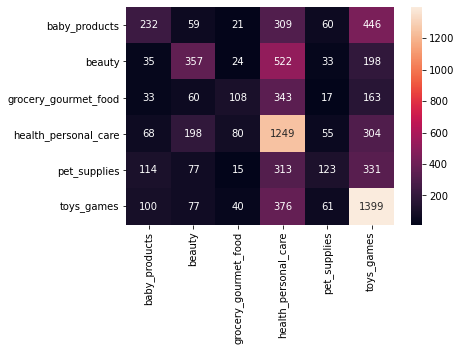

In [17]:
import seaborn as sns
classes = np.unique(y_test)
sns.heatmap(array, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

## Implementing auto hierachical classification

In [ ]:
from utils import hierarchical_classification

In [19]:
estimators, groups = hierarchical_classification(lr, X_train, y_train, metric=f1_score, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The most confused classes on iteration 0 are: beauty and health_personal_care
New classes are: ['baby_products' 'grocery_gourmet_food' 'group_0' 'pet_supplies'
 'toys_games']
Best f1_score on validation set is 0.4007046742626636
------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The most confused classes on iteration 1 are: grocery_gourmet_food and group_0
New classes are: ['baby_products' 'group_1' 'pet_supplies' 'toys_games']
Best f1_score on validation set is 0.486079683983423
------------------------------------------------------------
The most confused classes on iteration 2 are: group_1 and pet_supplies
New classes are: ['baby_products' 'group_2' 'toys_games']
Best f1_score on validation set is 0.5647435518891047
------------------------------------------------------------


In [20]:
groups

{'group_0': ['beauty', 'health_personal_care'],
 'group_1': ['grocery_gourmet_food', 'group_0'],
 'group_2': ['group_1', 'pet_supplies']}

## Changing the estimator

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

In [22]:
estimators, groups = hierarchical_classification(rf, X_train, y_train, metric=f1_score, random_state=42)

The most confused classes on iteration 0 are: beauty and health_personal_care
New classes are: ['baby_products' 'grocery_gourmet_food' 'group_0' 'pet_supplies'
 'toys_games']
Best f1_score on validation set is 0.37061295515621107
------------------------------------------------------------
The most confused classes on iteration 1 are: grocery_gourmet_food and group_0
New classes are: ['baby_products' 'group_1' 'pet_supplies' 'toys_games']
Best f1_score on validation set is 0.46590360174302914
------------------------------------------------------------
The most confused classes on iteration 2 are: group_1 and pet_supplies
New classes are: ['baby_products' 'group_2' 'toys_games']
Best f1_score on validation set is 0.5482817476180116
------------------------------------------------------------


## Changing the metric

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
estimators, groups = hierarchical_classification(lr, X_train, y_train, metric=accuracy_score, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The most confused classes on iteration 0 are: beauty and health_personal_care
New classes are: ['baby_products' 'grocery_gourmet_food' 'group_0' 'pet_supplies'
 'toys_games']
Best accuracy_score on validation set is 0.4315625
------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The most confused classes on iteration 1 are: grocery_gourmet_food and group_0
New classes are: ['baby_products' 'group_1' 'pet_supplies' 'toys_games']
Best accuracy_score on validation set is 0.540625
------------------------------------------------------------
The most confused classes on iteration 2 are: group_1 and pet_supplies
New classes are: ['baby_products' 'group_2' 'toys_games']
Best accuracy_score on validation set is 0.613125
------------------------------------------------------------
